In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import random
import torch
import os

from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout, Bidirectional, CuDNNLSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2

from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

Using TensorFlow backend.


In [2]:
def roc_auc_score_modified(y_true, y_pred):
    
    # to tackle problems where shuffled batches only contains 1 class
    # return 0.5, an underestimate of the actual metric
    
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return 0.5

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score_modified, (y_true, y_pred), tf.double)

def get_callbacks(file_path = None):
    earlystop = EarlyStopping(monitor='val_auroc', mode='max', verbose=1, patience=6)
    if file_path:
        checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')
        call_backs = [checkpoint,earlystop]
    else:
        call_backs = [earlystop]
    return call_backs

def get_model(num_features):    
    
    network_input = Input(shape=(1800, num_features))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(network_input) 
    conv1 = Conv1D(128, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform")(x)

    avg_pool1 = GlobalAveragePooling1D()(conv1)
    max_pool1 = GlobalMaxPooling1D()(conv1) 

    x = concatenate([avg_pool1, max_pool1])

    network_output = Dense(1, activation='sigmoid')(x)

    model = Model(network_input, network_output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-4),
                  metrics=['acc', auroc])
    return model

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
SEED = 123
seed_everything(123)

In [5]:
%%time


for n in range(1,6,1):

    print(f'Training Model - Fold {n}')

    X_train = np.load(f'../input/f{n}-final/Fold{n}_train_data.npy')
    y_train = np.load(f'../input/f{n}-final/Fold{n}_train_label.npy')
    X_val = np.load(f'../input/f{n}-final/Fold{n}_val_data.npy')
    y_val = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')

    print(X_train.shape)
    assert X_train.shape[0] == y_train.shape[0], 'Training file data and label doesnt match'
    assert X_val.shape[0] == y_val.shape[0], 'Validation file data and label doesnt match'

    file_path = f'fold{n}_best_weights.hdf5'
    call_backs = get_callbacks(file_path)

    model = get_model(X_train.shape[-1])

    for batch_size in [256, 512]:
        print(f'\nTraining with batch size {batch_size}\n')
        model.fit(X_train, y_train, 
                  batch_size=batch_size, epochs = 100, 
                  callbacks=call_backs, 
                  validation_data=(X_val, y_val), 
                  verbose=1)
        print('\nLoading best weight from file\n')
        model.load_weights(file_path)

    if n == 1:
        y_oof = model.predict(X_val)
    else:
        y_pred = model.predict(X_val)
        y_oof = np.row_stack([y_oof, y_pred])

    del X_train, y_train, X_val, y_val, model

    gc.collect()

Training Model - Fold 1
(15985, 1800, 12)
Instructions for updating:
Colocations handled automatically by placer.

Training with batch size 256

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15985 samples, validate on 3997 samples
Epoch 1/100
15985/15985 [==============================] - 35s 2ms/step - loss: 0.9918 - acc: 0.7604 - auroc: 0.5453 - val_loss: 0.9418 - val_acc: 0.7618 - val_auroc: 0.6198

Epoch 00001: val_auroc improved from -inf to 0.61983, saving model to fold1_best_weights.hdf5
Epoch 2/100
15985/15985 [==============================] - 23s 1ms/step - loss: 0.8923 - acc: 0.7684 - auroc: 0.6825 - val_loss: 0.8545 - val_acc: 0.7678 - val_auroc: 0.7112

Epoch 00002: val_auroc improved from 0.61983 to 0.71117, saving model to fold1_best_weights.hdf5
Epoch 3/100
15985/15985 [==============================] - 23s 1ms/step - loss: 0.8172 - acc: 0.7742 - auroc: 0.7285 - val_loss: 0.7971 - v

In [6]:
for n in range(1,6,1):
    if n == 1:
        y_true = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = y_true.reshape((y_true.shape[0],1))
    else:
        y_fold = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = np.row_stack([y_true, y_fold.reshape((y_fold.shape[0], 1))])

In [7]:
oof_rocauc = roc_auc_score(y_true, y_oof)
print(f'OOF ROCAUC Score : {oof_rocauc:.4f}')

OOF ROCAUC Score : 0.7481


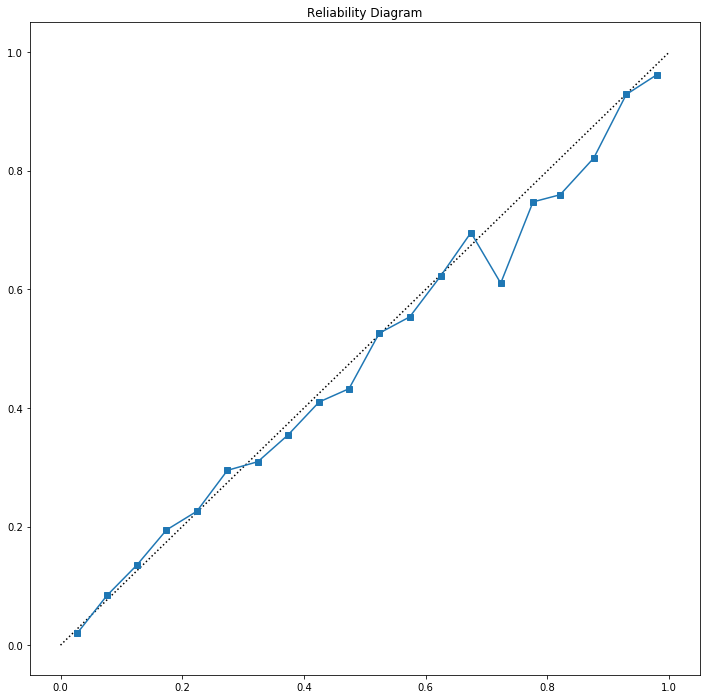

In [8]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_oof, n_bins =20)

plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='OOF prediction')
plt.title(f'Reliability Diagram')
plt.show()

In [9]:
np.save('LSTM_oof_predictions.npy', y_oof)